In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp


tf.compat.v1.disable_eager_execution()


"""
  Convolutional structure for the encoder net
"""
# Encoder for VAE

encoder = tf.keras.Sequential([
    layers.Conv2D(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=512, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Flatten()
])

"""
  DeConv structure for the decoder net
"""
# Decoder for VAE
decoder = tf.keras.Sequential([
    layers.Dense(2048),
    layers.Reshape(target_shape=(4, 4, 128), input_shape=(None, 1024)),
    layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=3  , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
])


batch_size = 250

x = tf.compat.v1.placeholder(tf.float32, shape=[batch_size, 32, 32, 3])

encoded = encoder(x)

mean = layers.Dense(1024, tf.nn.softplus)(encoded)
sigma = layers.Dense(1024, tf.nn.relu)(encoded)

z = mean + tf.multiply(tf.sqrt(tf.exp(sigma)),
                       tf.random.normal(shape=(batch_size, 1024)))

x_reco = decoder(z)



reconstruction_term = -tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(
    layers.Flatten()(x_reco), scale_identity_multiplier=0.05).log_prob(layers.Flatten()(x)))

kl_divergence = tf.reduce_sum(tf.keras.metrics.kullback_leibler_divergence(x, x_reco), axis=[1, 2])

cost = tf.reduce_mean(reconstruction_term + kl_divergence)



optimizer = tf.optimizers.Adam()

from tensorflow.keras.datasets.cifar10 import load_data
(X_train, y_train), (X_test, y_test) = load_data()

runs = 100
n_minibatches = int(X_train.shape[0] / batch_size)

print("Number of minibatches: ", n_minibatches)




Number of minibatches:  200


In [4]:
sess = tf.compat.v1.InteractiveSession()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)

for epoch in range(runs):
    pbar = tf.keras.utils.Progbar(n_minibatches)
    for i in range(n_minibatches):
        
        x_batch = X_train[i*batch_size:(i+1)*batch_size]/255.
        cost_ = sess.run((cost), feed_dict={x: x_batch})

        pbar.add(1,[("cost",cost_)])

200/200 [==============================] - 209s 1s/step - cost: 38440035.2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


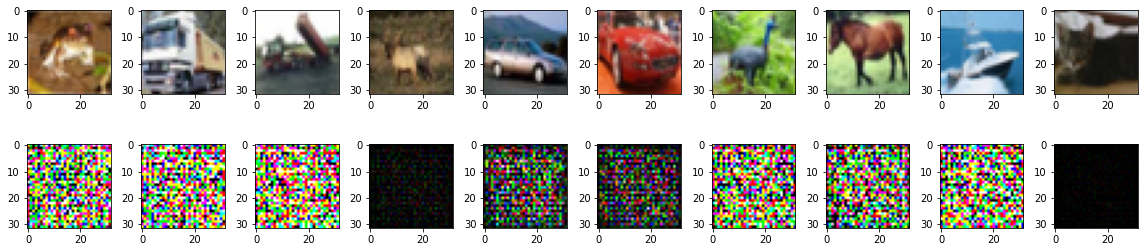

In [5]:
import matplotlib.pyplot as plt
import numpy as np

n_rec = 10

x_batch = X_train[0:batch_size]

plt.figure(figsize=(n_rec+6,4))

pred_img = sess.run(x_reco, feed_dict={x: x_batch})
pred_img = pred_img.reshape(batch_size, 32, 32, 3)
pred_img = pred_img.astype(np.int32)

for i in range(n_rec):
    
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_batch[i])

    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(pred_img[i])

plt.tight_layout()
